In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read csv with specified date column, drop unnecessary columns
df = pd.read_csv(
    "./data/super_rugby_oddsportal.csv", parse_dates =["Date"]
).drop(
    ['Play-off Game?', 'Bookmakers Surveyed'], axis=1  # drop unnecessary columns
)

# ** is this necessary ?
spare = pd.read_csv("./data/super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

# number of upcoming fixtures
n_matches = len(df[(df['Home Score']==0) & (df['Away Score']==0)])

df.head(n_matches)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds
0,2020-03-13,Chiefs,Hurricanes,0,0,1.39,24.81,3.01
1,2020-03-14,Blues,Lions,0,0,1.11,34.58,6.33
2,2020-03-14,Sunwolves,Crusaders,0,0,25.63,58.18,1.00
3,2020-03-14,Reds,Bulls,0,0,1.38,23.67,3.09
4,2020-03-14,Sharks,Stormers,0,0,1.51,22.65,2.60
5,2020-03-14,Jaguares,Highlanders,0,0,1.14,30.37,5.61
6,2020-03-15,Brumbies,Waratahs,0,0,1.19,28.66,4.71


---
## 1. Feature engineering
### Numeric columns
  - `home_margin` = `home_score` - `away_score`: score differential w.r.t. home team
  - `home_win` = `home_score` > `away_score`: did the home team win (1/0)?
    - We will use this in the next block to create a moving window of home / away team win rates
  - `home_odds` = `home_score` - `away_score`: transformed bookmakers' odds into form pr(home team win)

In [3]:
# standardise naming format
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

# extract year
# df['year'] = df['date'].apply(lambda x: x.year)

# add home margin column
df['home_margin'] = df['home_score'] - df['away_score']
# add home win column
df['home_win'] = (df['home_score'] > df['away_score']).astype('int')

# aggregate odds into single probability variable
df['home_odds'] = df['away_odds'] / (df['home_odds'] + df['away_odds'])
df.drop(['draw_odds', 'away_odds'], axis=1, inplace=True)

df.head(15)

,date,home_team,away_team,home_score,away_score,home_odds,home_margin,home_win
0,2020-03-13,Chiefs,Hurricanes,0,0,0.684091,0,0
1,2020-03-14,Blues,Lions,0,0,0.850806,0,0
2,2020-03-14,Sunwolves,Crusaders,0,0,0.037552,0,0
3,2020-03-14,Reds,Bulls,0,0,0.691275,0,0
4,2020-03-14,Sharks,Stormers,0,0,0.632603,0,0
5,2020-03-14,Jaguares,Highlanders,0,0,0.831111,0,0
6,2020-03-15,Brumbies,Waratahs,0,0,0.798305,0,0
7,2020-03-06,Sunwolves,Brumbies,14,47,0.064578,-33,0
8,2020-03-06,Crusaders,Reds,24,20,0.911864,4,1
9,2020-03-06,Waratahs,Chiefs,14,51,0.267081,-37,0


### Window functions
  - avg points scored by home side in last n games
  - avg points conceded by home side in last n games
  - avg points scored by away side in last n games
  - avg points conceded by away side in last n games

In [4]:
df = df.assign(
    # average odds for home_team in previous n home fixtures
    avg_hm_odd_5=df.groupby('home_team')['home_odds'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_hm_odd_10=df.groupby('home_team')['home_odds'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_hm_odd_20=df.groupby('home_team')['home_odds'].rolling(20).mean().shift(-20).reset_index(0, drop=True),
    # average odds for away team in previous n away fixtures
    avg_aw_odd_5= 1-df.groupby('away_team')['home_odds'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_aw_odd_10= 1-df.groupby('away_team')['home_odds'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_aw_odd_20= 1-df.groupby('away_team')['home_odds'].rolling(20).mean().shift(-20).reset_index(0, drop=True),
    # home team win rate previous n
    hm_wr_5=df.groupby('home_team')['home_win'].rolling(5).sum().shift(-5).reset_index(0, drop=True)/5,
    hm_wr_10=df.groupby('home_team')['home_win'].rolling(10).sum().shift(-10).reset_index(0, drop=True)/10,
    hm_wr_20=df.groupby('home_team')['home_win'].rolling(20).sum().shift(-20).reset_index(0, drop=True)/20,
    # away team win rate previous n
    aw_wr_5= 1-df.groupby('away_team')['home_win'].rolling(5).sum().shift(-5).reset_index(0, drop=True)/5,
    aw_wr_10= 1-df.groupby('away_team')['home_win'].rolling(10).sum().shift(-10).reset_index(0, drop=True)/10,
    aw_wr_20= 1-df.groupby('away_team')['home_win'].rolling(20).sum().shift(-20).reset_index(0, drop=True)/20,
    # average margin by home_team in previous n home fixtures
    avg_hm_marg_5=df.groupby('home_team')['home_margin'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_hm_marg_10=df.groupby('home_team')['home_margin'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_hm_marg_20=df.groupby('home_team')['home_margin'].rolling(20).mean().shift(-20).reset_index(0, drop=True)
)

df.drop(['date', 'home_score', 'away_score', 'home_win'], axis=1, inplace=True)

# drop the first 20 games in the dataset as they do not have any rolling features
df = df.dropna().reset_index(drop=True)

df.head(n_matches)

,home_team,away_team,home_odds,home_margin,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20
0,Chiefs,Hurricanes,0.684091,0,0.584055,0.592217,0.647742,0.458219,0.529461,0.595539,0.8,0.5,0.65,0.6,0.7,0.55,4.6,0.3,2.95
1,Blues,Lions,0.850806,0,0.482872,0.523303,0.535276,0.343240,0.400913,0.444212,0.2,0.6,0.40,0.0,0.3,0.30,-4.0,2.7,-1.85
2,Sunwolves,Crusaders,0.037552,0,0.162659,0.238055,0.220676,0.719473,0.716063,0.692157,0.2,0.1,0.20,0.6,0.6,0.70,-23.6,-20.5,-15.55
3,Reds,Bulls,0.691275,0,0.539380,0.521634,0.440761,0.311511,0.344013,0.343297,0.4,0.5,0.55,0.4,0.5,0.35,6.2,3.3,3.05
4,Sharks,Stormers,0.632603,0,0.622741,0.636494,0.637674,0.427570,0.348821,0.370611,0.6,0.5,0.60,0.4,0.3,0.20,2.4,0.0,3.30
5,Jaguares,Highlanders,0.831111,0,0.764683,0.708459,0.615034,0.310290,0.413124,0.476254,0.8,0.8,0.70,0.2,0.2,0.30,16.0,15.6,9.85
6,Brumbies,Waratahs,0.798305,0,0.692406,0.655131,0.585452,0.299202,0.373695,0.413995,0.8,0.9,0.70,0.4,0.3,0.40,10.6,12.0,8.75


### Categorical columns
  - home team / country
  - away team / country
  - year

In [5]:
# convert to pandas category dtypes
df[['home_team', 'away_team']] = df[['home_team', 'away_team']].astype('category')

df.head(n_matches)

,home_team,away_team,home_odds,home_margin,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20
0,Chiefs,Hurricanes,0.684091,0,0.584055,0.592217,0.647742,0.458219,0.529461,0.595539,0.8,0.5,0.65,0.6,0.7,0.55,4.6,0.3,2.95
1,Blues,Lions,0.850806,0,0.482872,0.523303,0.535276,0.343240,0.400913,0.444212,0.2,0.6,0.40,0.0,0.3,0.30,-4.0,2.7,-1.85
2,Sunwolves,Crusaders,0.037552,0,0.162659,0.238055,0.220676,0.719473,0.716063,0.692157,0.2,0.1,0.20,0.6,0.6,0.70,-23.6,-20.5,-15.55
3,Reds,Bulls,0.691275,0,0.539380,0.521634,0.440761,0.311511,0.344013,0.343297,0.4,0.5,0.55,0.4,0.5,0.35,6.2,3.3,3.05
4,Sharks,Stormers,0.632603,0,0.622741,0.636494,0.637674,0.427570,0.348821,0.370611,0.6,0.5,0.60,0.4,0.3,0.20,2.4,0.0,3.30
5,Jaguares,Highlanders,0.831111,0,0.764683,0.708459,0.615034,0.310290,0.413124,0.476254,0.8,0.8,0.70,0.2,0.2,0.30,16.0,15.6,9.85
6,Brumbies,Waratahs,0.798305,0,0.692406,0.655131,0.585452,0.299202,0.373695,0.413995,0.8,0.9,0.70,0.4,0.3,0.40,10.6,12.0,8.75


---
## 2. Find best model
  - To do: train neural network using embeddings for teams instead of one-hot encoding

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

In [7]:
X = df[n_matches:].drop(['home_margin'], axis=1)
y = df[n_matches:].home_margin.values

In [8]:
# upcoming week's fixtures
X_temp = df[:n_matches].drop(['home_margin'], axis=1)
y_temp = df[:n_matches].home_margin.values

In [9]:
y.shape

(963,)

In [10]:
X.shape

(963, 18)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)

In [12]:
X_train.head()

,home_team,away_team,home_odds,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20
7,Sunwolves,Brumbies,0.064578,0.202183,0.243343,0.220530,0.402190,0.395699,0.361580,0.2,0.1,0.25,0.6,0.4,0.35,-27.4,-17.3,-12.55
8,Crusaders,Reds,0.911864,0.809030,0.835835,0.821216,0.273540,0.271399,0.266292,1.0,0.9,0.95,0.0,0.2,0.15,16.4,20.8,20.75
9,Waratahs,Chiefs,0.267081,0.577688,0.548024,0.567216,0.513306,0.445852,0.457903,0.2,0.4,0.50,0.6,0.7,0.60,-7.0,-2.0,4.10
10,Hurricanes,Blues,0.672055,0.701329,0.675785,0.748131,0.478585,0.434480,0.432339,0.8,0.7,0.85,0.6,0.3,0.30,13.4,6.3,8.75
11,Rebels,Lions,0.638350,0.554917,0.627721,0.553597,0.294272,0.426571,0.461474,0.2,0.5,0.45,0.0,0.3,0.35,-13.8,-4.5,-2.30


In [13]:
categorical_columns = ['home_team', 'away_team']
numerical_columns = [col for col in X.columns if col not in categorical_columns]

categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder())
])
numerical_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

model = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])
model.fit(X_train, y_train)
print(f'Train RMSE: {np.sqrt(mean_squared_error(model.predict(X_train), y_train)):.3f}')
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.3f}\n')
# test data
print(f'Test RMSE: {np.sqrt(mean_squared_error(model.predict(X_test), y_test)):.3f}')
print(f'Test MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}')

Train RMSE: 10.530
Train MAE: 8.406

Test RMSE: 12.490
Test MAE: 9.461


### Evaluate performance

In [14]:
import seaborn as sns; sns.set()

C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


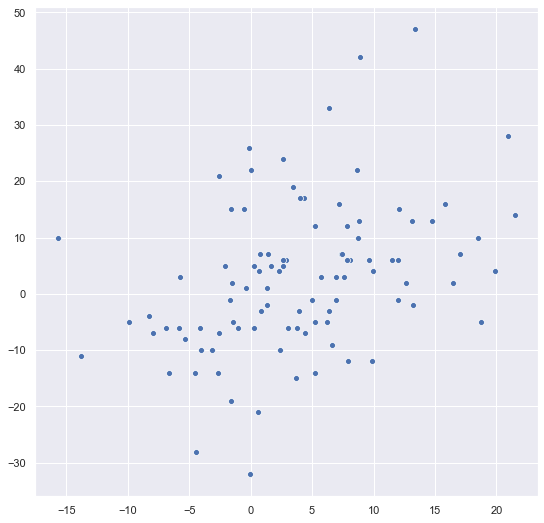

In [15]:
plt.figure(figsize=(9,9))
sns.scatterplot(model.predict(X_test), y_test)
plt.show()

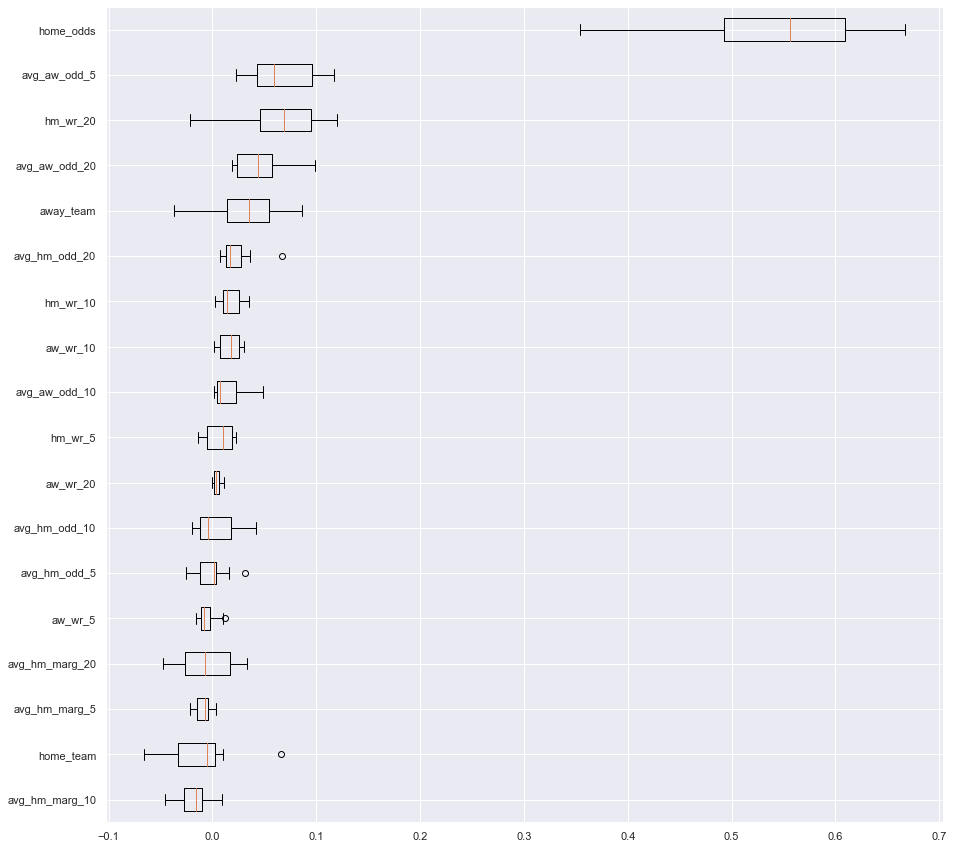

In [16]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(15,15))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_test.columns[sorted_idx])
plt.show()

### Train on all data (if not overfitting)

In [17]:
model.fit(X, y)

print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X), y)):.3f}')
print(f'MAE: {mean_absolute_error(y, model.predict(X)):.3f}')

RMSE: 10.757
MAE: 8.508


## 3. Make predictions for upcoming week

In [18]:
# predict for upcoming week
np.vstack((model.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

array([[7.136948292000312, 'Chiefs', 'Hurricanes'],
       [9.922563400343394, 'Blues', 'Lions'],
       [-13.274234604061414, 'Sunwolves', 'Crusaders'],
       [2.7934485842027934, 'Reds', 'Bulls'],
       [5.622641173782229, 'Sharks', 'Stormers'],
       [22.298077789459295, 'Jaguares', 'Highlanders'],
       [14.630952830234664, 'Brumbies', 'Waratahs']], dtype=object)

In [19]:
temp = np.vstack((model.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

In [20]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [21]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,7,Chiefs,Hurricanes
1,10,Blues,Lions
2,-13,Sunwolves,Crusaders
3,3,Reds,Bulls
4,6,Sharks,Stormers
5,22,Jaguares,Highlanders
6,15,Brumbies,Waratahs


---
## Neural network

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Concatenate, Dropout, LeakyReLU
from tensorflow.keras.models import Model

In [24]:
n_home, n_away = X['home_team'].nunique(), X['away_team'].nunique()
n_home, n_away

(18, 18)

In [25]:
# home team embeddings
home_in = Input(shape=[1])
home_em = Embedding(n_home, 5)(home_in)
home_vec = Flatten()(home_em)
# away team embeddings
away_in = Input(shape=[1])
away_em = Embedding(n_away, 5)(away_in)
away_vec = Flatten()(away_em)
# form features
form_in = Input(shape=[16])
# concatenate user and item vectors
conc = Concatenate()([home_vec, away_vec, form_in])
# hidden layer
x = Dense(64, activation='relu')(conc)
x = Dropout(.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(.2)(x)
# output
scoreline = Dense(1)(x)

# create model and compile it
model = Model([home_in, away_in, form_in], scoreline)
model.compile(optimizer='adam', loss='mean_squared_error')

# show summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         90          input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 5)         90          input_2[0][0]                    
______________________________________________________________________________________________

In [28]:
from sklearn.preprocessing import LabelEncoder

Train on 692 samples, validate on 174 samples
Epoch 1/10
692/692 [==============================] - 0s 91us/sample - loss: 280.8968 - val_loss: 140.5932
Epoch 2/10
692/692 [==============================] - 0s 70us/sample - loss: 282.9098 - val_loss: 139.5228
Epoch 3/10
692/692 [==============================] - 0s 69us/sample - loss: 275.7632 - val_loss: 139.0631
Epoch 4/10
692/692 [==============================] - 0s 73us/sample - loss: 271.7759 - val_loss: 137.6086
Epoch 5/10
692/692 [==============================] - 0s 69us/sample - loss: 263.1311 - val_loss: 137.0543
Epoch 6/10
692/692 [==============================] - 0s 69us/sample - loss: 261.5154 - val_loss: 136.5000
Epoch 7/10
692/692 [==============================] - 0s 71us/sample - loss: 261.3135 - val_loss: 137.9652
Epoch 8/10
692/692 [==============================] - 0s 76us/sample - loss: 253.7832 - val_loss: 138.5008
Epoch 9/10
692/692 [==============================] - 0s 71us/sample - loss: 248.5186 - val_loss: 

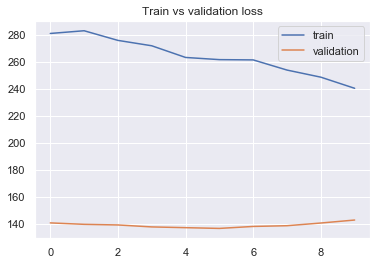

In [33]:
le = LabelEncoder()

# train rating model on all data
result = model.fit(
    x=[le.fit_transform(X_train['home_team'].values), le.transform(X_train['away_team'].values), X_train.iloc[:,2:].values],
    y=y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=.2
)

# plot training curve of best model
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='validation')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

In [34]:
preds = model.predict(
    x=[le.transform(X_test['home_team'].values), le.transform(X_test['away_team'].values), X_test.iloc[:,2:].values]
)

# test data
print(f'Test RMSE: {np.sqrt(mean_squared_error(preds, y_test)):.3f}')
print(f'Test MAE: {mean_absolute_error(preds, y_test):.3f}')

Test RMSE: 13.123
Test MAE: 10.019


In [39]:
preds = model.predict(
    x=[le.transform(X_temp['home_team'].values), le.transform(X_temp['away_team'].values), X_temp.iloc[:,2:].values]
).reshape(1,-1)

preds

temp = np.vstack((preds, spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

In [40]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [41]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,-1,Chiefs,Hurricanes
1,-2,Blues,Lions
2,-16,Sunwolves,Crusaders
3,5,Reds,Bulls
4,5,Sharks,Stormers
5,10,Jaguares,Highlanders
6,8,Brumbies,Waratahs
